# Отключаем сообщения

In [26]:
from transformers import logging
logging.set_verbosity_error() # set_verbosity_warning()

import warnings
warnings.filterwarnings("ignore")

# Чанки 

In [27]:
from langchain_community.document_loaders import TextLoader, Docx2txtLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

def file_to_chunks(file_name, sep, chunk_size, chunk_overlap):
    file_ext = file_name.split('.')[-1]
    file_path = f'{TEST_FOLDER_PATH}/{file_name}'
    
    # Загружаем содержимое файла 
    if file_ext == 'txt':
        loader = TextLoader(file_path, encoding='utf-8')
    elif file_ext == 'docx':
        loader = Docx2txtLoader(file_path)
    elif file_ext == 'pdf':
        loader = PyPDFLoader(file_path)
    else:
        return
    file = loader.load()
    content = file[0].page_content
    
    # Разбиваем текст на чанки
    text_splitter = RecursiveCharacterTextSplitter(
        separators = sep,
        chunk_size = chunk_size,
        chunk_overlap = chunk_overlap,
        length_function = len,
        is_separator_regex = False,
        add_start_index = False
    )
    chunks = text_splitter.split_text(content)
    
    return chunks

# Bi-encoder 

In [28]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import Pooling, Transformer

# Подгружаем bi-encoder 
def get_bi_encoder(bi_encoder_name):
    raw_model = Transformer(model_name_or_path=f'{bi_encoder_name}')

    # Вытаскиваем размер векторов
    bi_encoder_dim = raw_model.get_word_embedding_dimension()
    
    pooling_model = Pooling(
        bi_encoder_dim,
        pooling_mode_cls_token = False,
        pooling_mode_mean_tokens = True
    )
    bi_encoder = SentenceTransformer(
        modules = [raw_model, pooling_model],
        device = 'cuda' # помещаем его на GPU
    )
    
    return bi_encoder, bi_encoder_dim

# Формируем из строки вектор
def str_to_vec(bi_encoder, text):
    embeddings = bi_encoder.encode(
        text,
        convert_to_tensor = True,
        show_progress_bar = False
    )
    return embeddings

# Qdrant

In [29]:
import uuid

from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct


# Создаем подключение к векторной БД
qdrant_client = QdrantClient('my_qdrant_server.ru', port=6333)   

# Помещаем чанки и доп. информаицю в векторую БД
def save_chunks(bi_encoder, chunks, file_name):
    # Конвертируем чанки в векитора
    chunk_embeddings = str_to_vec(bi_encoder, chunks)

    # Содаем объект(ы) для БД
    points = []
    for i in range(len(chunk_embeddings)):
        point = PointStruct(
            id=str(uuid.uuid4()), # генерируем GUID
            vector = chunk_embeddings[i], 
            payload={'file': file_name, 'chunk': chunks[i]}
        )
        points.append(point)
    
    # Сохраняем вектора в БД
    operation_info = qdrant_client.upsert(
        collection_name = COLL_NAME,
        wait = True,
        points = points
    )
    
    return operation_info

def files_to_vecdb(files, bi_encoder, vec_size, sep, chunk_size, chunk_overlap):    
    # Удаляем и заново создаем коллекцию
    qdrant_client.delete_collection(collection_name=COLL_NAME)
    qdrant_client.create_collection(
        collection_name = COLL_NAME,
        vectors_config = VectorParams(size=vec_size, distance=Distance.COSINE),
    )
    
    # Каждый файл по одному...
    for file_name in files:
        # делим на чанки ...
        chunks = file_to_chunks(file_name, sep, chunk_size, chunk_overlap)
        # помещаем чанки в векторную БД
        operation_status = save_chunks(bi_encoder, chunks, file_name)

# Поиск векторов

In [30]:
def vec_search(bi_encoder, query, n_top_cos):
    # Кодируем запрос в вектор
    query_emb = str_to_vec(bi_encoder, query)

    # Поиск в БД
    search_result = qdrant_client.search(
        collection_name = COLL_NAME,
        query_vector = query_emb,
        limit = n_top_cos,
        with_vectors = False
    )
    
    top_chunks = [x.payload['chunk'] for x in search_result]
    top_files = list(set([x.payload['file'] for x in search_result]))
    
    return top_chunks, top_files

# LLM

In [31]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = 'IlyaGusev/saiga_llama3_8b'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
def get_llm_answer(query, chunks_join, max_new_tokens, temperature, top_p, top_k):
    user_prompt = '''Используй только следующий контекст, чтобы очень кратко ответить на вопрос в конце.
    Не пытайся выдумывать ответ.
    Контекст:
    ===========
    {chunks_join}
    ===========
    Вопрос:
    ===========
    {query}'''.format(chunks_join=chunks_join, query=query)
    
    SYSTEM_PROMPT = "Ты — Сайга, русскоязычный автоматический ассистент. Ты разговариваешь с людьми и помогаешь им."
    RESPONSE_TEMPLATE = "<|im_start|>assistant\n"
    
    prompt = f'''<|im_start|>system\n{SYSTEM_PROMPT}<|im_end|>\n<|im_start|>user\n{user_prompt}<|im_end|>\n{RESPONSE_TEMPLATE}'''
    
    def generate(model, tokenizer, prompt):
        data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
        data = {k: v.to(model.device) for k, v in data.items()}
        output_ids = model.generate(
            **data,
            bos_token_id=128000,
            eos_token_id=128001,
            pad_token_id=128001,
            do_sample=True,
            max_new_tokens=max_new_tokens,
            no_repeat_ngram_size=15,
            repetition_penalty=1.1,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p 
        )[0]
        output_ids = output_ids[len(data["input_ids"][0]) :]
        output = tokenizer.decode(output_ids, skip_special_tokens=True)
        return output.strip()
    
    response = generate(model, tokenizer, prompt)
    
    return response

# Оценка

In [34]:
import re
import json
from rouge import Rouge
from pymorphy2 import MorphAnalyzer

f = open('stopwords-ru.json', encoding='utf-8')
stop_words = json.load(f)
#print(stop_words)

morph = MorphAnalyzer()
patterns = "[«»°!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(string):
    clear = re.sub(patterns, ' ', string)
    tokens = []
    for token in clear.split():
        if token:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            if token not in stop_words:
                tokens.append(token)
    tokens = ' '.join(tokens)
    return tokens

def get_llm_score(answer, answer_true):
    answer = lemmatize(answer)
    answer_true = lemmatize(answer_true)
    if len(answer) == 0:
        answer = '-'
        
    rouge = Rouge()
    scores = rouge.get_scores(answer, answer_true)[0]
    rouge_1 = round(scores['rouge-1']['r']*100, 2)
    
    return rouge_1

In [35]:
def get_context_score(chunks_join, context):
    rouge = Rouge()
    scores = rouge.get_scores(chunks_join, context)[0]
    score = round(scores['rouge-l']['r'] * 100)
    return score

# Выполнение теста

In [36]:
def run_one_test(df, encoder_name, sep, chunk_size, chunk_overlap, n_top_cos, max_new_tokens, temperature, top_p, top_k):
    try:
        bi_encoder, vec_size = get_bi_encoder(encoder_name)

        files = df['Файл'].unique()
        files_to_vecdb(files, bi_encoder, vec_size, sep, chunk_size, chunk_overlap)

        result = []
        for i, row in df.iterrows():
            query = row['Вопрос']
            answer_true = row['Правильный ответ']
            file_name = row['Файл']
            context = row['Контекст']

            top_chunks, top_files = vec_search(bi_encoder, query, n_top_cos)
            row['top_files'] = top_files
            row['top_chunks'] = top_chunks
            top_chunks_join = '\n'.join(top_chunks) # объединяем чанки

            answer = get_llm_answer(query, top_chunks_join, max_new_tokens, temperature, top_p, top_k)
            row['Ответ'] = answer

            row['file_score'] = int(file_name in top_files)
            row['context_score'] = get_context_score(top_chunks_join, context)
            row['llm_score'] = get_llm_score(answer, answer_true)

            result.append(row)

        result = pd.DataFrame(result)
        result = result.sort_values(by=['llm_score','context_score','file_score'], ascending=False)
        result = result.reset_index(drop=True)

        score = result['llm_score'].mean()

        return result, score
    
    except:
        return None, 0

# Запуск Optuna'ы

In [35]:
import optuna

def objective(trial):
    global best_score, best_result
    
    encoder_name = trial.suggest_categorical('encoder_name', ['cointegrated/rubert-tiny2',
                                                              'kazzand/ru-longformer-large-4096',
                                                              'cointegrated/LaBSE-en-ru'])
    sep = trial.suggest_categorical('sep', ['.',' ','\n'])
    
    chunk_size = trial.suggest_int('chunk_size', 100, 2000)
    chunk_overlap = trial.suggest_int('chunk_overlap', 50, 600)
    n_top_cos = trial.suggest_int('n_top_cos', 1, 8)
    
    max_new_tokens = trial.suggest_int('max_new_tokens', 100, 1600)
    temperature = trial.suggest_float('temperature', 0.01, 0.99)
    top_p = trial.suggest_float('top_p', 0.01, 0.99)
    top_k = trial.suggest_int('top_k', 10, 150)
    
    result, score = run_one_test(
        TEST_DF,
        encoder_name,
        sep, chunk_size, chunk_overlap, n_top_cos,
        max_new_tokens, temperature, top_p, top_k
    )
    
    if score > best_score:
        best_score = score
        best_score_tag = ' <--'
        best_result = result
    else:
        best_score_tag = ''       

    print(f'{score:.2f}', best_score_tag)
    
    return score

optuna.logging.set_verbosity(optuna.logging.WARNING) 

In [ ]:
import pandas as pd

COLL_NAME = 'optuna_test_llama3_1'
TEST_FILE_PATH = 'ru_rag_test_dataset.pkl'
TEST_FOLDER_PATH = 'Тест_RuBQ'

TEST_DF = pd.read_pickle(TEST_FILE_PATH)[::15]
print('Кол-во строк:', TEST_DF.shape[0])


best_score = 0
best_result = None

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5000, timeout=60*60*24)

# Результат

In [11]:
opuna_df = study.trials_dataframe()
opuna_df

,number,value,datetime_start,datetime_complete,duration,params_chunk_overlap,params_chunk_size,params_encoder_name,params_max_new_tokens,params_n_top_cos,params_sep,params_temperature,params_top_k,params_top_p,state
0,0,0.000000,2024-04-25 10:18:01.649689,2024-04-25 10:18:02.573977,0 days 00:00:00.924288,450,319,cointegrated/LaBSE-en-ru,316,7,\n,0.930892,149,0.702310,COMPLETE
1,1,55.845806,2024-04-25 10:18:02.574354,2024-04-25 10:19:30.605047,0 days 00:01:28.030693,193,1785,cointegrated/LaBSE-en-ru,1514,4,\n,0.027537,70,0.652660,COMPLETE
2,2,39.579516,2024-04-25 10:19:30.605287,2024-04-25 10:21:23.361061,0 days 00:01:52.755774,221,1151,kazzand/ru-longformer-large-4096,523,2,\n,0.487919,124,0.805136,COMPLETE
3,3,43.655968,2024-04-25 10:21:23.361679,2024-04-25 10:22:13.166769,0 days 00:00:49.805090,544,1260,cointegrated/rubert-tiny2,1026,1,\n,0.558888,14,0.454970,COMPLETE
4,4,39.931774,2024-04-25 10:22:13.167027,2024-04-25 10:23:02.124023,0 days 00:00:48.956996,237,1730,cointegrated/rubert-tiny2,742,2,,0.380677,64,0.419516,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,477,71.975000,2024-04-26 06:05:02.576918,2024-04-26 06:07:34.393376,0 days 00:02:31.816458,77,1916,cointegrated/LaBSE-en-ru,408,8,\n,0.702029,139,0.250517,COMPLETE
478,478,75.890161,2024-04-26 06:07:34.393676,2024-04-26 06:10:38.655517,0 days 00:03:04.261841,61,1970,cointegrated/LaBSE-en-ru,376,8,\n,0.673494,119,0.270870,COMPLETE
479,479,55.551290,2024-04-26 06:10:38.655805,2024-04-26 06:13:15.009669,0 days 00:02:36.353864,68,2000,kazzand/ru-longformer-large-4096,426,8,\n,0.656991,123,0.223920,COMPLETE
480,480,68.480323,2024-04-26 06:13:15.010239,2024-04-26 06:15:51.182856,0 days 00:02:36.172617,91,1931,cointegrated/LaBSE-en-ru,357,8,\n,0.682191,127,0.140111,COMPLETE


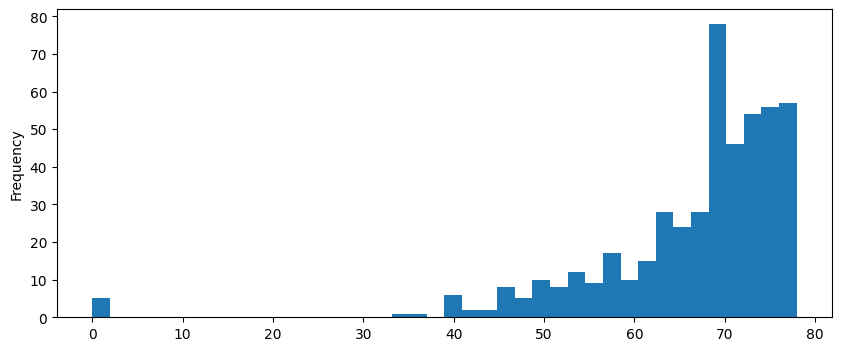

In [14]:
opuna_df['value'].plot(kind='hist', bins=40, figsize=(10, 4));

In [19]:
print('Лучшее значение:', study.best_value)
print('Среднее значение:', opuna_df['value'].mean())
print('Медианное значение:', opuna_df['value'].median())

Лучшее значение: 77.95903225806452
Среднее значение: 66.55820974434481
Медианное значение: 69.71693548387097


In [37]:
study.best_params

{'encoder_name': 'cointegrated/LaBSE-en-ru',
 'sep': '\n',
 'chunk_size': 1977,
 'chunk_overlap': 61,
 'n_top_cos': 8,
 'max_new_tokens': 302,
 'temperature': 0.6095279086616815,
 'top_p': 0.1871688966686985,
 'top_k': 129}

In [20]:
best_result

,Вопрос,Правильный ответ,Контекст,Файл,top_files,top_chunks,Ответ,file_score,context_score,llm_score
0,Что может вызвать цунами?,Землетрясение,"Землетрясения, извержения вулканов и другие по...",19985.txt,[19985.txt],[== Причины образования цунами ==\nЗемлетрясен...,Цунами могут вызывать следующие причины:\n\n* ...,1,100,100.0
1,Кто заложил основы кибернетики?,Винер,Термин «кибернетика» изначально ввёл в научный...,13000.txt,[13000.txt],[=== Направления ===\nКибернетика — более ранн...,"Ответ: Норберт Винер. Он ввёл термин ""кибернет...",1,100,100.0
2,Кто из ахейцев-героев Троянской войны был муже...,Агамемнон,"Клитемне́стра (др.-греч. Κλυταιμνήστρα, встреч...",107225.txt,"[6416631.txt, 36565.txt, 107225.txt]","[Елена (Ἑλένη) — дочь Зевса, спартанская царев...",Ответ: Никто из ахейцев-героев Троянской войны...,1,100,100.0
3,"Кто из персонажей романа Л.Н.Толстого ""Война и...",Пьер Безухов,После оставления Наполеоном Москвы Наташа сбли...,390982.txt,"[390982.txt, 7007113.txt, 43369.txt, 36225.txt]",[== Образ Наташи ==\nЧастичными прототипами На...,Ответ: Пьер Безухов.,1,100,100.0
4,Какой город является столицей Свазиленда?,Мбабане,Официальная столица страны — Мбабане (94 874 ч...,6345.txt,"[142837.txt, 157308.txt, 6345.txt]",[== СМИ ==\nГосударственная телекомпания Swazi...,Мбабане.,1,100,100.0
...,...,...,...,...,...,...,...,...,...,...
57,Какой город стоит на реке Печора?,Нарьян-Мар,Регулярное судоходство возможно до Троицко-Печ...,169533.txt,"[199620.txt, 169533.txt, 19308.txt, 36565.txt]",[Повесть начинается с прибытия Печорина в Пяти...,"Печорин - петербуржец. Военный, как по своему ...",1,26,0.0
58,В каком направлении писал Тютчев?,"романтизм, пантеизм",Фёдор Ива́нович Тю́тчев (23 ноября [5 декабря]...,45777.txt,"[45777.txt, 157308.txt]",[=== Любовная лирика ===\nВ любовной лирике Ф....,"Тютчев - русский поэт, писатель и дипломат. Он...",1,26,0.0
59,Кто муж Юлии Меньшовой?,Игорь Гордин,Муж — Игорь Геннадьевич Гордин (род. 6 мая 196...,362585.txt,"[157308.txt, 32724.txt, 36225.txt, 362585.txt,...",[Произведения Михаила Юрьевича Лермонтова в Ви...,Муж Юлии Меньшовой - Александр Смирнов.,1,18,0.0
60,Когда написан Герой нашего времени?,1839 г,«Геро́й на́шего вре́мени» — первый в русской п...,199620.txt,"[157308.txt, 36565.txt, 33904.txt, 53688.txt, ...","[== Герои ==\n\n\n=== Шурик ===\n\nПерсонаж, и...","Шурик - персонаж из фильмов Леонида Гайдая, из...",0,17,0.0


In [43]:
cols = ['Вопрос', 'Правильный ответ', 'Ответ', 'file_score', 'context_score', 'llm_score']
best_result[cols].head(10)

,Вопрос,Правильный ответ,Ответ,file_score,context_score,llm_score
0,Что может вызвать цунами?,Землетрясение,Цунами могут вызывать следующие причины:\n\n* ...,1,100,100.0
1,Кто заложил основы кибернетики?,Винер,"Ответ: Норберт Винер. Он ввёл термин ""кибернет...",1,100,100.0
2,Кто из ахейцев-героев Троянской войны был муже...,Агамемнон,Ответ: Никто из ахейцев-героев Троянской войны...,1,100,100.0
3,"Кто из персонажей романа Л.Н.Толстого ""Война и...",Пьер Безухов,Ответ: Пьер Безухов.,1,100,100.0
4,Какой город является столицей Свазиленда?,Мбабане,Мбабане.,1,100,100.0
5,В каком городе пребывает Международный суд ООН?,Гаага,"Международный суд ООН находится в Гааге, Нидер...",1,100,100.0
6,"Кто снял фильмы ""Космос как предчувствие"", ""Пр...",Алексей Учитель,"Ответ: Фильм ""Космос как предчувствие"" снял Ал...",1,100,100.0
7,Чья песня Sweet dreams?,Eurythmics,"Эта песня - ""Sweet Dreams (Are Made of This)"" ...",1,100,100.0
8,На каких языках говорят в Тайланде?,Тайский язык,"В Таиланде говорят на тайском языке, который я...",1,100,100.0
9,В каком году обнаружили реликтовое излучение?,1948,Реликтовое излучение было обнаружено в 1964 го...,1,100,100.0


In [42]:
cols = ['Вопрос', 'Правильный ответ', 'Ответ', 'file_score', 'context_score', 'llm_score']
best_result[cols].tail(12)

,Вопрос,Правильный ответ,Ответ,file_score,context_score,llm_score
50,В каком году завершилась Первая мировая?,11 ноября 1918,В 1918 году.,1,34,33.33
51,Какое административное деление Великобритании?,"Англия включает в себя 9 регионов, 6 метрополь...",Административное деление Великобритании включа...,1,100,8.70
52,В каком году построена Эйфелева башня?,28 января 1887 г,1889 год.,1,100,0.00
53,К какой династии относился Ричард Львиное Сердце?,Плантагенет,Династия Плантагенетов.,1,98,0.00
54,Какой фильм снял польский режиссер А. Вайда по...,Пилат и другие,Ответ: В 1971 году польским режиссёром Анджей ...,1,98,0.00
55,К какой династии принадлежал Людовик 18?,Юурбонов,Людовик XVIII - член династии Бурбонов.,1,96,0.00
56,"Кто автор философского трактата ""О природе вещ...",Тит Лукреций Кар,Аристотель.,0,29,0.00
57,Какой город стоит на реке Печора?,Нарьян-Мар,"Печорин - петербуржец. Военный, как по своему ...",1,26,0.00
58,В каком направлении писал Тютчев?,"романтизм, пантеизм","Тютчев - русский поэт, писатель и дипломат. Он...",1,26,0.00
59,Кто муж Юлии Меньшовой?,Игорь Гордин,Муж Юлии Меньшовой - Александр Смирнов.,1,18,0.00


In [23]:
cols = ['value', 'params_chunk_overlap', 'params_chunk_size', 'params_encoder_name',
       'params_max_new_tokens', 'params_sep', 'params_temperature',
       'params_n_top_cos', 'params_top_k', 'params_top_p']
opuna_df[cols].sort_values(by='value', ascending=False).head(9).T

,250,292,346,275,289,375,356,263,269
value,77.959032,77.78371,77.78371,77.78371,77.78371,77.78371,77.78371,77.78371,77.78371
params_chunk_overlap,61,63,50,66,67,50,62,58,64
params_chunk_size,1977,1962,1963,1958,1959,1963,1964,1958,1959
params_encoder_name,cointegrated/LaBSE-en-ru,cointegrated/LaBSE-en-ru,cointegrated/LaBSE-en-ru,cointegrated/LaBSE-en-ru,cointegrated/LaBSE-en-ru,cointegrated/LaBSE-en-ru,cointegrated/LaBSE-en-ru,cointegrated/LaBSE-en-ru,cointegrated/LaBSE-en-ru
params_max_new_tokens,302,368,284,346,374,320,294,338,323
params_sep,\n,\n,\n,\n,\n,\n,\n,\n,\n
params_temperature,0.609528,0.641928,0.627547,0.686538,0.726211,0.618854,0.655322,0.639575,0.655517
params_n_top_cos,8,8,8,8,8,8,8,8,8
params_top_k,129,128,128,125,127,123,132,128,126
params_top_p,0.187169,0.117106,0.208512,0.130048,0.146543,0.196747,0.147141,0.164283,0.122811


# Один тест

In [38]:
params = study.best_params
params['df'] = TEST_DF
params

{'encoder_name': 'cointegrated/LaBSE-en-ru',
 'sep': '\n',
 'chunk_size': 1977,
 'chunk_overlap': 61,
 'n_top_cos': 8,
 'max_new_tokens': 302,
 'temperature': 0.6095279086616815,
 'top_p': 0.1871688966686985,
 'top_k': 129,
 'df':                                                 Вопрос  \
 0                            Что может вызвать цунами?   
 15   К какой династии относился Ричард Львиное Сердце?   
 30                     Кто заложил основы кибернетики?   
 45   Кто из ахейцев-героев Троянской войны был муже...   
 60   Кто из персонажей романа Л.Н.Толстого "Война и...   
 ..                                                 ...   
 855                Когда написан Герой нашего времени?   
 870                       Сколько сезонов в Ворониных?   
 885  Где происходит оплодотворение яйцеклетки у жен...   
 900                      Как мать Григория Перельмана?   
 915                 Кто спроектировал Кёльнский собор?   
 
                Правильный ответ  \
 0                 Земле

In [ ]:
result, score = run_one_test(**params)
result

In [40]:
score

76.34612903225806

In [41]:
result

,Вопрос,Правильный ответ,Контекст,Файл,top_files,top_chunks,Ответ,file_score,context_score,llm_score
0,Что может вызвать цунами?,Землетрясение,"Землетрясения, извержения вулканов и другие по...",19985.txt,[19985.txt],[== Причины образования цунами ==\nЗемлетрясен...,Цунами могут вызывать следующие причины:\n\n* ...,1,100,100.0
1,Кто заложил основы кибернетики?,Винер,Термин «кибернетика» изначально ввёл в научный...,13000.txt,[13000.txt],[=== Направления ===\nКибернетика — более ранн...,"Ответ: Норберт Винер. Он ввёл термин ""кибернет...",1,100,100.0
2,Кто из ахейцев-героев Троянской войны был муже...,Агамемнон,"Клитемне́стра (др.-греч. Κλυταιμνήστρα, встреч...",107225.txt,"[107225.txt, 6416631.txt, 36565.txt]","[Елена (Ἑλένη) — дочь Зевса, спартанская царев...",Ответ: Никто из ахейцев-героев Троянской войны...,1,100,100.0
3,"Кто из персонажей романа Л.Н.Толстого ""Война и...",Пьер Безухов,После оставления Наполеоном Москвы Наташа сбли...,390982.txt,"[36225.txt, 390982.txt, 43369.txt, 7007113.txt]",[== Образ Наташи ==\nЧастичными прототипами На...,Ответ: Пьер Безухов.,1,100,100.0
4,Какой город является столицей Свазиленда?,Мбабане,Официальная столица страны — Мбабане (94 874 ч...,6345.txt,"[142837.txt, 6345.txt, 157308.txt]",[== СМИ ==\nГосударственная телекомпания Swazi...,Мбабане.,1,100,100.0
...,...,...,...,...,...,...,...,...,...,...
57,В каком направлении писал Тютчев?,"романтизм, пантеизм",Фёдор Ива́нович Тю́тчев (23 ноября [5 декабря]...,45777.txt,"[45777.txt, 157308.txt]",[=== Любовная лирика ===\nВ любовной лирике Ф....,"Тютчев - русский поэт, писатель и дипломат. Он...",1,26,0.0
58,Кто муж Юлии Меньшовой?,Игорь Гордин,Муж — Игорь Геннадьевич Гордин (род. 6 мая 196...,362585.txt,"[362585.txt, 32724.txt, 36225.txt, 157308.txt,...",[Произведения Михаила Юрьевича Лермонтова в Ви...,Муж Юлии Меньшовой - Александр Смирнов.,1,18,0.0
59,В каком направлении писал Лермонтов?,"романтизм, реализм",Михаи́л Ю́рьевич Ле́рмонтов (3 [15] октября 18...,32724.txt,[32724.txt],[Произведения Михаила Юрьевича Лермонтова в Ви...,Лермонтов писал в основном в жанрах лирической...,1,18,0.0
60,Когда написан Герой нашего времени?,1839 г,«Геро́й на́шего вре́мени» — первый в русской п...,199620.txt,"[53688.txt, 33904.txt, 36565.txt, 36225.txt, 1...","[== Герои ==\n\n\n=== Шурик ===\n\nПерсонаж, и...","Шурик - персонаж из фильмов Леонида Гайдая, из...",0,17,0.0
